In [ ]:
pip install --upgrade google-api-python-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 42.4 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.151.0
    Uninstalling google-api-python-client-2.151.0:
      Successfully uninstalled google-api-python-client-2.151.0


In [ ]:
pip install isodate

In [ ]:
pip install python-dateutil

In [ ]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import isodate
from dateutil import parser
import matplotlib.pyplot as plt
import pytz
from datetime import datetime, timedelta

In [ ]:
api = # Insert your Youtube API here

In [ ]:
channel_ids = ['UCh3seRrAKSqsex1rYov6RLA'#telenovia
               # Insert more channels here for comparison
            ]

In [ ]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api)

In [ ]:
# Get Channel Stats

def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:

    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs

    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist

    """
    all_data = []

    for channel_id in channel_ids:
        #Make the request for each channel ID separately
        request = youtube.channels().list(
            part="snippet,contentDetails,statistics",
            id=','.join(channel_ids)
        )
        response = request.execute()

        # Check if 'items' key exists before accessing it
        if 'items' in response and response['items']:
            item = response['items'][0] # Get the first item, which should be the channel data
            data = {'channelName': item['snippet']['title'],
                    'subscribers': item['statistics']['subscriberCount'],
                    'views': item['statistics']['viewCount'],
                    'totalViews': item['statistics']['videoCount'],
                    'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
                    }
            all_data.append(data)
        else:
            print(f"No data found for channel ID: {channel_id}")

    return pd.DataFrame(all_data)

In [ ]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [ ]:
channel_stats

,channelName,subscribers,views,totalViews,playlistId
0,telenovia,86,9353,35,UUh3seRrAKSqsex1rYov6RLA


In [ ]:
# Get Video ID

playlist_id = "UUh3seRrAKSqsex1rYov6RLA"

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:

    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel

    Returns:
    List of video IDs of all videos in the playlist

    """

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId=playlist_id,
            maxResults=50
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids

In [ ]:
video_ids = get_video_ids(youtube, playlist_id)

In [ ]:
len(video_ids)

36

In [ ]:
# Define the mapping of videoCategoryId to YouTube category names
category_mapping = {
    '1': 'Film & Animation',
    '2': 'Autos & Vehicles',
    '10': 'Music',
    '15': 'Pets & Animals',
    '17': 'Sports',
    '19': 'Travel & Events',
    '20': 'Gaming',  # Gaming category ID
    '21': 'News & Politics',
    '22': 'Entertainment',
    '23': 'People & Blogs',
    '24': 'Comedy',
    '25': 'How-to & Style',
    '26': 'Education',
    '27': 'Science & Technology',
    '28': 'Nonprofits & Activism',
    '29': 'Movies',
    '30': 'Shows',
    '31': 'Trailers',
}

In [ ]:
# Get Video Details

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:

    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs

    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt', 'categoryID'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet, contentDetails, statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt', 'categoryId'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                             }
            video_info = {}
            video_info['video_id'] = video['id']

            # Map categoryId to game category
            category_id = video['snippet'].get('categoryId', None)
            video_info['gameCategory'] = category_mapping.get(category_id, 'Unknown')

            # Try to infer the game title from the video title, description, and tags
            video_info['gameTitle'] = 'Unknown Game'
            title = video['snippet'].get('title', '').lower()
            description = video['snippet'].get('description', '').lower()

            # Check if the game title appears in the title or description
            if 'minecraft' in title or 'minecraft' in description:
                video_info['gameTitle'] = 'Minecraft'
            elif 'fortnite' in title or 'fortnite' in description:
                video_info['gameTitle'] = 'Fortnite'
            elif 'league of legends' in title or 'league of legends' in description:
                video_info['gameTitle'] = 'League of Legends'
            elif 'valorant' in title or 'valorant' in description:
                video_info['gameTitle'] = 'Valorant'
            elif 'dota 2' in title or 'dota 2' in description:
                video_info['gameTitle'] = 'Dota 2'
            elif 'overwatch' in title or 'overwatch' in description:
                video_info['gameTitle'] = 'Overwatch'
            elif 'fears to fathom' in title or 'fears to fathom' in description:
                video_info['gameTitle'] = 'Fears to Fathom'
            elif 'rainbow six siege' in title or 'rainbow six siege' in description:
                video_info['gameTitle'] = 'Rainbow Six Siege'

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            # Calculate watch hours (views * duration in hours)
            duration_iso = video_info.get('duration')
            view_count = int(video_info.get('viewCount', 0))
            duration_hours = isodate.parse_duration(duration_iso).total_seconds() / 3600 if duration_iso else 0
            watch_hours = duration_hours * view_count

            video_info['duration_hours'] = duration_hours
            video_info['watch_hours'] = watch_hours

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [ ]:
# Get Video Details
video_df = get_video_details(youtube, video_ids)

In [ ]:
video_df

,video_id,gameCategory,gameTitle,channelTitle,title,description,tags,publishedAt,categoryId,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,duration_hours,watch_hours
0,CF8OQdOODWQ,Gaming,Unknown Game,telenovia,lowrank adventure | join twitch to interact!,watch my stream here - https://twitch.tv/telen...,None,2024-11-17T15:26:02Z,20,0,0,None,0,PT2M12S,hd,false,0.036667,0.000000
1,UukzEk9QJD8,Gaming,Unknown Game,telenovia,lowrank adventure | join twitch to interact!,watch my stream here - https://twitch.tv/telen...,None,2024-11-17T15:26:02Z,20,40,2,None,0,PT44M8S,hd,false,0.735556,29.422222
2,2rrGhRwE4g0,Gaming,Dota 2,telenovia,gnatuk | DOTA 2 INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-17T15:26:00Z,20,54,5,None,0,PT3H31M30S,hd,false,3.525000,190.350000
3,-rifs1STkuc,Gaming,Dota 2,telenovia,GAMEPLAY CIAMIK | DOTA 2 INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-15T18:09:46Z,20,60,5,None,0,PT3H31M31S,hd,false,3.525278,211.516667
4,K6gkvcNAk7s,Gaming,Dota 2,telenovia,GAMEPLAY CIAMIK | DOTA 2 INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-15T17:59:03Z,20,0,0,None,0,P0D,sd,false,0.000000,0.000000
5,hOdzkoVRNWQ,Gaming,Dota 2,telenovia,(restrim) WWWWWWWWWWWWWWWWW | DOTA 2 INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-14T19:59:38Z,20,70,6,None,0,PT2H7M17S,hd,false,2.121389,148.497222
6,kLFcsvZGpYk,Gaming,Dota 2,telenovia,WWWWWWWWWWWWWWWWW | DOTA 2 INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-14T17:52:08Z,20,46,5,None,0,PT3H52M53S,hd,false,3.881389,178.543889
7,RGbCLi1qZ2o,Gaming,Fears to Fathom,telenovia,TERROR: TELENOVIA MAIN HORROR #23 | FEARS TO F...,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-14T04:52:17Z,20,40,4,None,0,PT1H48M26S,hd,false,1.807222,72.288889
8,LisWs8H-B9Y,Gaming,Valorant,telenovia,bentar aja | VALORANT INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-12T06:57:10Z,20,52,5,None,0,PT2H34M57S,hd,false,2.582500,134.290000
9,pVhmAH5EIvU,Gaming,Valorant,telenovia,SCRIMMAGE | VALORANT INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-12T06:50:42Z,20,65,9,None,0,PT2H17M14S,hd,false,2.287222,148.669444


# Data Pre-Processing

In [ ]:
# Checking Missing Values
print("Missing Values:")
print(video_df.isnull().any())

Missing Values:
video_id          False
gameCategory      False
gameTitle         False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
categoryId        False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
duration_hours    False
watch_hours       False
dtype: bool


In [ ]:
# Checking Data Types
print("\nData Types:")
print(video_df.dtypes)


Data Types:
video_id           object
gameCategory       object
gameTitle          object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
categoryId         object
viewCount          object
likeCount          object
favouriteCount     object
commentCount       object
duration           object
definition         object
caption            object
duration_hours    float64
watch_hours       float64
dtype: object


In [ ]:
# Converting Columns to Numeric Dtypes

video_df['viewCount'] = video_df['viewCount'].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Apply time zone

timezone = pytz.timezone('Asia/Jakarta')

# Ensure 'publishedAt' is a datetime object and apply timezone localization

if video_df['publishedAt'].dtype == 'datetime64[ns]':
    # Apply timezone localization directly if no timezone info exists
    video_df['publishedAt'] = video_df['publishedAt'].apply(
        lambda x: x if x.tzinfo else timezone.localize(x)
    )
else:
    # Convert to datetime and localize
    video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt']).apply(
        lambda x: x if x.tzinfo else timezone.localize(x)
    )

In [ ]:
# Duration Conversion and Filtering

video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds() if x else 0)
video_df = video_df[video_df['durationSecs'] >= 60]  # Filter videos shorter than 1 minute
video_df['durationHours'] = video_df['durationSecs'] / 3600

<ipython-input-22-eda9302b0380>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_df['durationHours'] = video_df['durationSecs'] / 3600


In [ ]:
# Extract Day of the Week

video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

<ipython-input-23-f7cfa2d2b687>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))


In [ ]:
# Watch Hours Calculation

video_df['watchHours'] = video_df['viewCount'] * video_df['durationHours']

<ipython-input-24-d2baef7f1996>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_df['watchHours'] = video_df['viewCount'] * video_df['durationHours']


In [ ]:
# Grouping by Game Title

game_watch_hours = video_df.groupby('gameTitle')['watchHours'].sum().reset_index()
game_watch_hours = game_watch_hours.sort_values(by='watchHours', ascending=False)

In [ ]:
# Cumulative Watch Hours and Progress Tracking

now = datetime.now(timezone)
recent_videos_365 = video_df[video_df['publishedAt'] > (now - timedelta(days=365))]
recent_videos_365['CumulativeWatchHours'] = recent_videos_365['watchHours'].cumsum()

<ipython-input-26-e9d793d0ee32>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_videos_365['CumulativeWatchHours'] = recent_videos_365['watchHours'].cumsum()


In [ ]:
# Total Watch Hours for Last 365 Days

total_watch_hours_last_365_days = recent_videos_365['watchHours'].sum()

In [ ]:
recent_videos_365

,video_id,gameCategory,gameTitle,channelTitle,title,description,tags,publishedAt,categoryId,viewCount,...,duration,definition,caption,duration_hours,watch_hours,durationSecs,durationHours,publishDayName,watchHours,CumulativeWatchHours
0,CF8OQdOODWQ,Gaming,Unknown Game,telenovia,lowrank adventure | join twitch to interact!,watch my stream here - https://twitch.tv/telen...,None,2024-11-17 15:26:02+00:00,20,0,...,PT2M12S,hd,false,0.036667,0.000000,132.0,0.036667,Sunday,0.000000,0.000000
1,UukzEk9QJD8,Gaming,Unknown Game,telenovia,lowrank adventure | join twitch to interact!,watch my stream here - https://twitch.tv/telen...,None,2024-11-17 15:26:02+00:00,20,40,...,PT44M8S,hd,false,0.735556,29.422222,2648.0,0.735556,Sunday,29.422222,29.422222
2,2rrGhRwE4g0,Gaming,Dota 2,telenovia,gnatuk | DOTA 2 INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-17 15:26:00+00:00,20,54,...,PT3H31M30S,hd,false,3.525000,190.350000,12690.0,3.525000,Sunday,190.350000,219.772222
3,-rifs1STkuc,Gaming,Dota 2,telenovia,GAMEPLAY CIAMIK | DOTA 2 INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-15 18:09:46+00:00,20,60,...,PT3H31M31S,hd,false,3.525278,211.516667,12691.0,3.525278,Friday,211.516667,431.288889
5,hOdzkoVRNWQ,Gaming,Dota 2,telenovia,(restrim) WWWWWWWWWWWWWWWWW | DOTA 2 INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-14 19:59:38+00:00,20,70,...,PT2H7M17S,hd,false,2.121389,148.497222,7637.0,2.121389,Thursday,148.497222,579.786111
6,kLFcsvZGpYk,Gaming,Dota 2,telenovia,WWWWWWWWWWWWWWWWW | DOTA 2 INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-14 17:52:08+00:00,20,46,...,PT3H52M53S,hd,false,3.881389,178.543889,13973.0,3.881389,Thursday,178.543889,758.330000
7,RGbCLi1qZ2o,Gaming,Fears to Fathom,telenovia,TERROR: TELENOVIA MAIN HORROR #23 | FEARS TO F...,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-14 04:52:17+00:00,20,40,...,PT1H48M26S,hd,false,1.807222,72.288889,6506.0,1.807222,Thursday,72.288889,830.618889
8,LisWs8H-B9Y,Gaming,Valorant,telenovia,bentar aja | VALORANT INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-12 06:57:10+00:00,20,52,...,PT2H34M57S,hd,false,2.582500,134.290000,9297.0,2.582500,Tuesday,134.290000,964.908889
9,pVhmAH5EIvU,Gaming,Valorant,telenovia,SCRIMMAGE | VALORANT INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-12 06:50:42+00:00,20,65,...,PT2H17M14S,hd,false,2.287222,148.669444,8234.0,2.287222,Tuesday,148.669444,1113.578333
10,otVqK3juUF8,Gaming,Valorant,telenovia,BEEN A WHILE | VALORANT INDONESIA,TLNV9 (10% off on your order) - https://www.in...,"[dota2, dota, indonesia, twitchstreamer, twitc...",2024-11-11 09:36:50+00:00,20,125,...,PT5H39M19S,hd,false,5.655278,706.909722,20359.0,5.655278,Monday,706.909722,1820.488056


# Data Visualization

## Cumulative Watch Hours Progress

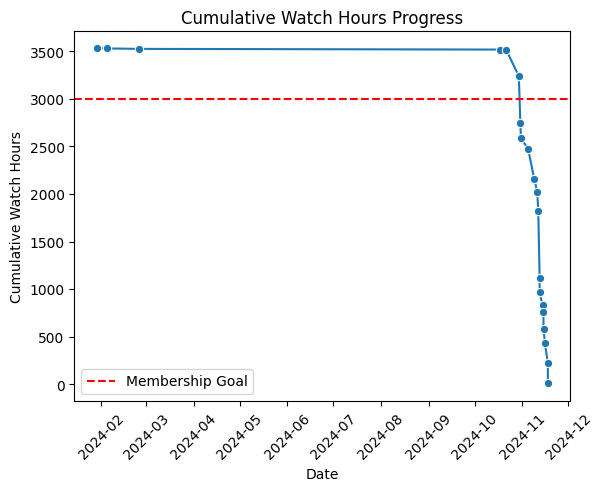

In [ ]:
sns.lineplot(data=recent_videos_365, x='publishedAt', y='CumulativeWatchHours', marker='o')
plt.axhline(3000, color='red', linestyle='--', label='Membership Goal')
plt.title('Cumulative Watch Hours Progress')
plt.xlabel('Date')
plt.ylabel('Cumulative Watch Hours')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Daily Watch Hours Distribution

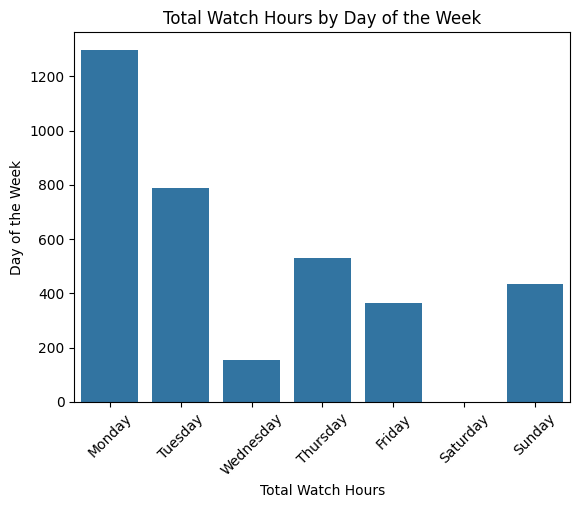

In [ ]:
watch_hours_by_day = video_df.groupby('publishDayName')['watchHours'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

sns.barplot(x=watch_hours_by_day.index, y=watch_hours_by_day)
plt.title('Total Watch Hours by Day of the Week')
plt.xlabel('Total Watch Hours')
plt.ylabel('Day of the Week')
plt.xticks(rotation=45)
plt.show()

## Video Performance

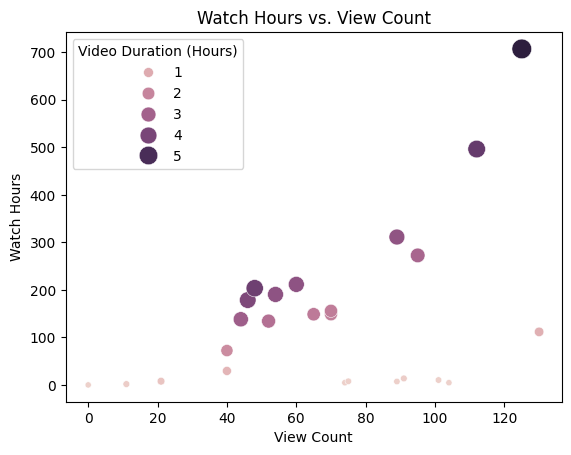

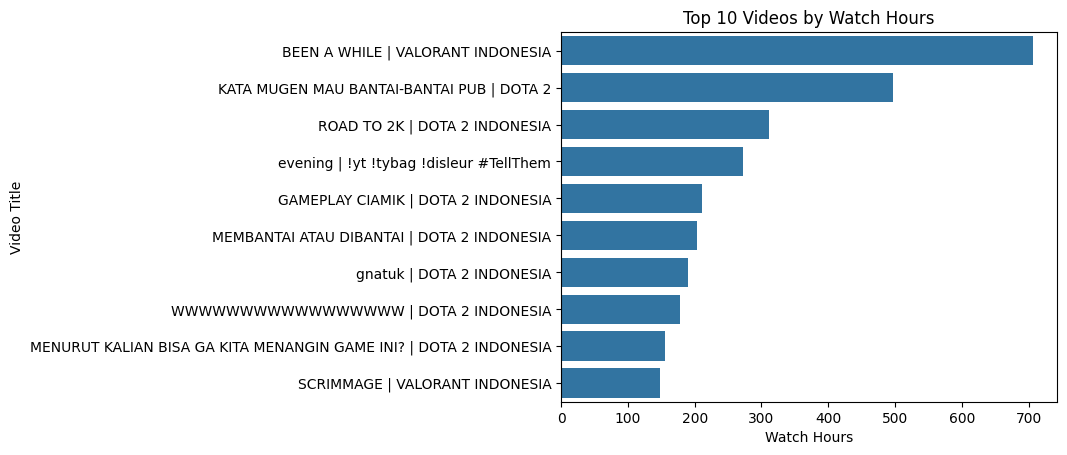

In [ ]:
# Scatter Plot: Watch hours vs. View count
sns.scatterplot(data=video_df, x='viewCount', y='watchHours', hue='durationHours', size='durationHours', sizes=(20, 200))
plt.title('Watch Hours vs. View Count')
plt.xlabel('View Count')
plt.ylabel('Watch Hours')
plt.legend(title='Video Duration (Hours)')
plt.show()

# Bar Plot: Top 10 videos by watch hours
top_videos = video_df.nlargest(10, 'watchHours')

sns.barplot(x='watchHours', y='title', data=top_videos, orient='h')
plt.title('Top 10 Videos by Watch Hours')
plt.xlabel('Watch Hours')
plt.ylabel('Video Title')
plt.show()

## Game Category Watch Hours

<ipython-input-32-4c1dc232d632>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=game_watch_hours, x='gameTitle', y='watchHours', palette='rocket')


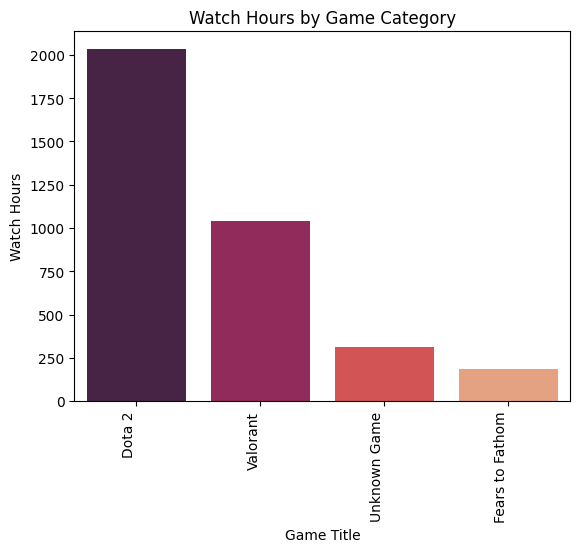

In [ ]:
sns.barplot(data=game_watch_hours, x='gameTitle', y='watchHours', palette='rocket')
plt.title('Watch Hours by Game Category')
plt.xlabel('Game Title')
plt.ylabel('Watch Hours')
plt.xticks(rotation=90, ha='right')
plt.show()

## Recent 30-Day Performance

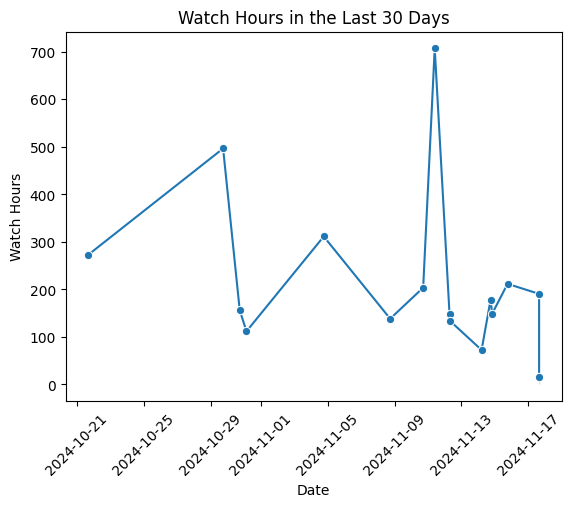

In [ ]:
recent_30_days = video_df[video_df['publishedAt'] > (now - timedelta(days=30))]
sns.lineplot(data=recent_30_days, x='publishedAt', y='watchHours', marker='o')
plt.title('Watch Hours in the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Watch Hours')
plt.xticks(rotation=45)
plt.show()

## Video Duration and Engagement

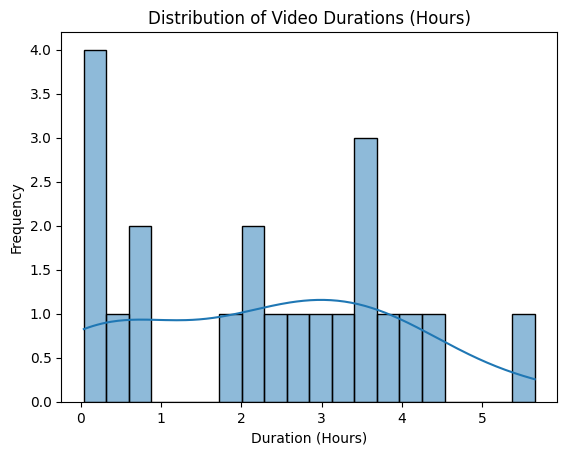

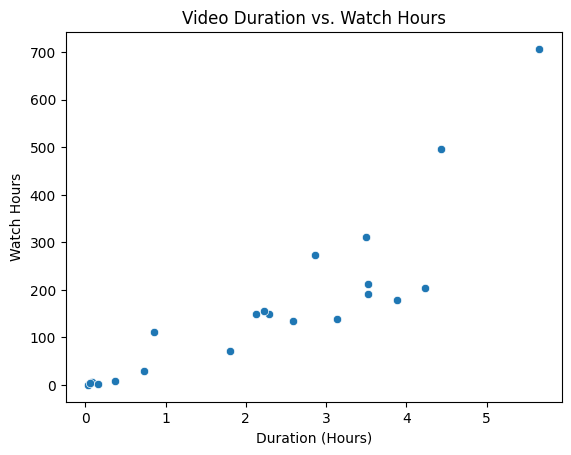

In [ ]:
# Histogram: Video durations
sns.histplot(data=recent_videos_365, x='durationHours', bins=20, kde=True)
plt.title('Distribution of Video Durations (Hours)')
plt.xlabel('Duration (Hours)')
plt.ylabel('Frequency')
plt.show()

# Scatter Plot: Duration vs. Watch Hours
sns.scatterplot(data=recent_videos_365, x='durationHours', y='watchHours')
plt.title('Video Duration vs. Watch Hours')
plt.xlabel('Duration (Hours)')
plt.ylabel('Watch Hours')
plt.show()

## Monthly Watch Hours Trends

<ipython-input-40-1dde5256e4ed>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  recent_videos_365['month'] = recent_videos_365['publishedAt'].dt.to_period('M')
<ipython-input-40-1dde5256e4ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_videos_365['month'] = recent_videos_365['publishedAt'].dt.to_period('M')


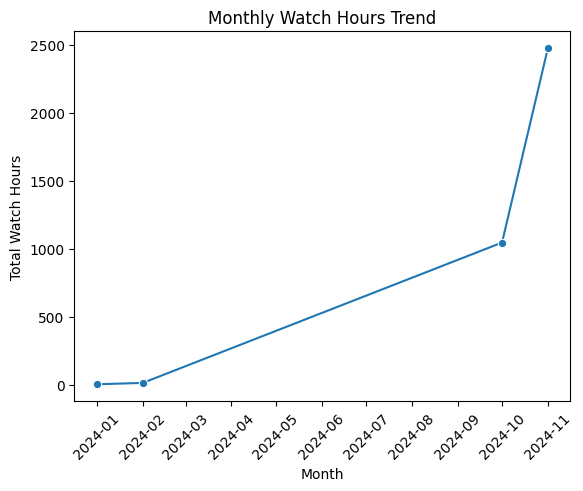

In [ ]:
recent_videos_365['month'] = recent_videos_365['publishedAt'].dt.to_period('M')
monthly_watch_hours = recent_videos_365.groupby('month')['watchHours'].sum().reset_index()

# Convert the 'month' column back to a datetime format for proper plotting
monthly_watch_hours['month'] = monthly_watch_hours['month'].dt.to_timestamp()

sns.lineplot(data=monthly_watch_hours, x='month', y='watchHours', marker='o')
plt.title('Monthly Watch Hours Trend')
plt.xlabel('Month')
plt.ylabel('Total Watch Hours')
plt.xticks(rotation=45)
plt.show()